# Matter Physics Lab
This notebook contains the data analysis for the following wl (wave lenght) spectra:
 1. [Black Body](#black-body-radiation) at T = 960 C.
 2. [Sodium lamp](#sodium-lamp-spectrum); 
 3. [He-Ne laser](#sodium-lamp-spectrum);
   
The spectra are used to characterize the experimental setup.

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib import rcParams
import modules.utils as utils
from importlib import reload
from functools import partial
from typing import Literal
reload(utils)

OUT_PATHS = {
    'figs_dir' : './figures',
    'results_dir' : './results',
}
IN_PATHS = {
    'black_body_dir' : './raw_data/Black_Body_Radiation',
    'na_dir' : './raw_data/Na_Spectrum',
    'ruby_dir' : './raw_data/Ruby_Spectrum',
    'laser_dir' : './raw_data/Laser_Spectrum',
}

# default figure settings
FIG_SIZE = np.array([6.4, 4]) # 16:10 aspect ratio
SAVE_FIG = True
FIG_FMT = 'pdf'
TRANSPARENT_PNG=True

# setting up stuff
savefig = partial(utils.save_fig, fig_dir=OUT_PATHS['figs_dir'], fig_fmt=FIG_FMT, fig_size=FIG_SIZE, save=SAVE_FIG, transparent_png=TRANSPARENT_PNG)
utils.check_paths(IN_PATHS, OUT_PATHS)

# style helpers
def fmtax(ax, label : bool | Literal['x', 'y'] = False, loc = 'upper left'):
    if label == True:
        ax.set_xlabel(r'wavelength [nm]')
        ax.set_ylabel(r'intensity [a.u.]')
    elif label == 'x':
        ax.set_xlabel(r'wavelength [nm]')
    elif label == 'y':
        ax.set_ylabel(r'intensity [a.u.]')
    ax.legend(loc=loc, frameon=False)
    ax.tick_params(direction='in', which='both')
    ax.minorticks_on()

## Black Body Radiation
This is the cleaned spectrum of the Black Body. In this context the spectrum is 'cleaned' because the stepper motor encoder reads values with an error and the error stacks across the wl sweep.
We took 6 slices of the spectrum and then sticked them together to get the full spectrum with an error that is almost constant accross all the wls. The error is not certain but it's for sure less than an Angstrom.

C:\Users\alber\AppData\Local\Temp\ipykernel_25888\4111703126.py:5: ParserWarning: Both a converter and dtype were specified for column meta - only the converter will be used.
  BB_Exp_df = pd.read_csv(path.join(OUT_PATHS['results_dir'], 'black_body.csv'),


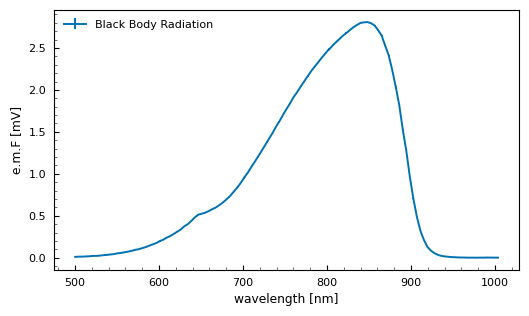

In [4]:
from os import path
from IPython.display import Latex, display

# Black Body dataframe
BB_Exp_df = pd.read_csv(path.join(OUT_PATHS['results_dir'], 'black_body.csv'),
                        dtype='float64', 
                        converters={'meta' : str})

# the wl will be in nanometers but the data is in angstroms
# so we must divide by 10 to get the correct units
BB_Exp_df['wl'] = BB_Exp_df['wl'] / 10
BB_Exp_df[['mean', 'std']] = BB_Exp_df[['mean', 'std']] * 1000

with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):
    fig, ax = plt.subplots(figsize=[6, 3.375])
    ax.errorbar(BB_Exp_df['wl'], BB_Exp_df['mean'], yerr=BB_Exp_df['std'], label='Black Body Radiation')
    fmtax(ax, label='x')
    ax.set_ylabel(r'e.m.F [mV]')
    plt.show()
    savefig(fig, fig_name = 'black_body_combined')

Actually this plot is an errorbar plot but the errors are not visible beacuse they are too small:

In [5]:
print(BB_Exp_df['mean'].agg(['min', 'max']).apply(lambda x: f"{x:.2e}"))
print(BB_Exp_df['std'].agg(['min', 'max']).apply(lambda x: f"{x:.2e}"))

min    0.00e+00
max    2.81e+00
Name: mean, dtype: object
min    0.00e+00
max    8.74e-03
Name: std, dtype: object


Here we want to fit the theoretical BB spectrum on top of the experimental measurements. We suppose they are proportional to eachother and fit for the proportionality constant. Only on the far left the proportionality relation holds so we fit in that region, after that the responce function is different from one and can be used to model the experimental responce.

1.9864458571489286e-25


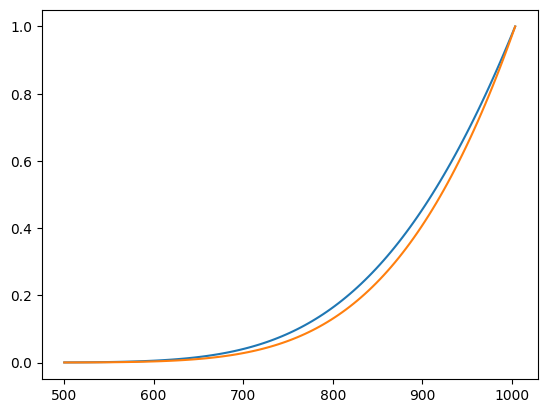

In [6]:
from scipy.optimize import curve_fit

# fitting for the proportionality coeff
fit = lambda x, a :  a * x
wl = BB_Exp_df['wl']
mean = BB_Exp_df['mean']
theo = utils.plank(wl * 1e-9, 1240)

print(utils.hc)

# correting for single photon counting
# plt.plot(wl, theo, label='Theoretical')
photon_energy  = utils.hc /  (wl * 1e-9) 

plt.plot(wl, theo / theo.max(), label='Theoretical')
theo = theo / photon_energy
plt.plot(wl, theo / theo.max(), label='Theoretical corrected')
plt.show()


Get the responce function of the system. The first part of the responce it's noisy so it's best to do a linear regression

until 642.7165893554688
LinregressResult(slope=-0.0011480446517289585, intercept=1.4727041006446058, rvalue=-0.8733197055418143, pvalue=3.703483826899176e-12, stderr=0.00010982634848309475, intercept_stderr=0.06301988623426753)


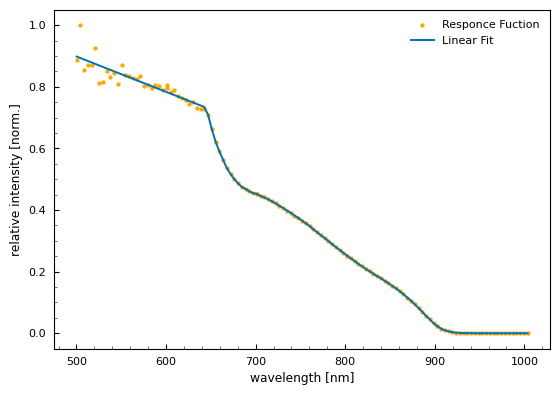

In [7]:
from scipy.stats import linregress

# responce function of the setup
responce = mean / theo
std = BB_Exp_df['std'] / theo

# normalize the responce
responce = responce / responce.max()

with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):
    fig, ax = plt.subplots()
    ax.scatter(wl, responce, c='orange', marker='.', label='Responce Fuction')
    
    
    # linear fit of the responce function until
    # the discontinuity point (knee) in the data
    print('until', wl[35])
    res = linregress(wl[:36], responce[:36])
    print(res)
    
    # update responce with the linear fit
    responce[:36] = np.polyval(res[:2], wl[:36])    
    ax.plot(wl, responce, label='Linear Fit')

    fmtax(ax, label='x', loc='upper right')
    ax.set(ylabel=r'relative intensity [norm.]')    
    plt.show()
    savefig(fig, fig_name = 'responce_fit')

# save the responce function
np.savetxt(path.join(OUT_PATHS['results_dir'], 'responce.csv'),
           np.array([wl, responce]).T, delimiter=',')

## Sodium Lamp Spectrum
The monochromator can have a slight shift in the measured wl. For calibrating the shift we use the known spectral lines of the sodium atoms in a sodium vapor lamp.
First of all we import the dataframe 

In [8]:
Na_files = utils.getFiles(IN_PATHS['na_dir'])
Na_df = pd.DataFrame([utils.file_to_series(file) for file in Na_files])

# convert angstroms to nanometers
Na_df['wl'] = Na_df['wl'] / 10
Na_df['samples'] = Na_df['wl'].apply(lambda x: len(x))
Na_df

,type,date,id,interval,wl,mean,std,meta,samples
0,Na,29102024,010,"[8175.2007, 8205.0]","[817.5201, 817.5404, 817.5604, 817.5805, 817.6...","[-7.35e-06, -6.33e-06, -5.16e-06, -6.1e-06, -5...","[1.8570494e-06, 7.233948e-07, 1.6485246e-06, 1...","{'type': 'Na', 'integration time': '1000ms', '...",149
1,Na,29102024,004,"[5880.303, 5910.0]","[588.03033, 588.06067, 588.09094, 588.1213, 58...","[1.33e-06, 1e-06, 1e-06, 1e-06, 1.33e-06, 1e-0...","[5.7735025e-07, 0.0, 0.0, 0.0, 5.7735025e-07, ...","{'type': 'Na', 'integration time': '300ms', 'P...",99
2,Na,17102024,001,"[5850.962, 5935.0]","[585.0962, 585.1674, 585.2387, 585.30994, 585....","[-3.67e-06, -2.67e-06, -3e-06, -3e-06, -3.33e-...","[1.1547004e-06, 2.5166114e-06, 0.0, 0.0, 2.886...","{'type': 'Na', 'integration time': '300ms', 'P...",119
3,Na,17102024,002,"[5880.321, 5910.0]","[588.0321, 588.0438, 588.0558, 588.06775, 588....","[5e-06, 4.33e-06, 5e-06, 4.33e-06, 5e-06, 5e-0...","[0.0, 1.1547004e-06, 0.0, 1.1547004e-06, 0.0, ...","{'type': 'Na', 'integration time': '300ms', 'P...",249
4,Na,17102024,003,"[5880.303, 5910.0]","[588.03033, 588.06067, 588.09094, 588.1213, 58...","[7e-08, 1.3e-07, 2.7e-07, 3e-08, 3e-08, 3.3e-0...","[2.5166116e-07, 5.7735026e-08, 5.7735033e-08, ...","{'type': 'Na', 'integration time': '300ms', 'P...",99
5,Na,17102024,004,"[5883.2734, 5910.0]","[588.32733, 588.3546, 588.3818, 588.40906, 588...","[2e-06, -2.67e-06, -4.33e-06, -1e-06, -2e-06, ...","[1.7320509e-06, 2.5166114e-06, 1.1547004e-06, ...","{'type': 'Na', 'integration time': '300ms', 'P...",99
6,Na,17102024,005,"[5880.1045, 5910.0]","[588.01044, 588.04095, 588.0714, 588.1019, 588...","[0.0, -6.7e-07, 1.7e-07, 0.0, 0.0, -5e-07, -3....","[5e-07, 2.8867515e-07, 2.8867512e-07, 5e-07, 5...","{'type': 'Na', 'integration time': '300ms', 'P...",99
7,Na,17102024,006,"[5885.2007, 5910.0]","[588.5201, 588.5299, 588.54, 588.55, 588.56006...","[1.7e-07, 6.7e-07, 0.0, 3.3e-07, 6.7e-07, 1.7e...","[2.8867515e-07, 2.8867512e-07, 5e-07, 7.637626...","{'type': 'Na', 'integration time': '300ms', 'P...",249
8,Na,17102024,007,"[5879.921, 5910.0]","[587.99207, 588.0043, 588.0164, 588.02856, 588...","[5e-08, -5e-08, 1.7e-07, 1.7e-07, 2e-08, -1e-0...","[5e-08, 3.0413813e-07, 1.4433756e-07, 2.753785...","{'type': 'Na', 'integration time': '300ms', 'P...",249
9,Na,17102024,008,"[5885.168, 5910.0]","[588.5168, 588.53357, 588.5504, 588.5672, 588....","[-7e-08, 2e-07, 2.7e-07, 7e-08, 9e-08, -1e-08,...","[1.9502137e-07, 1.0115994e-07, 2.8687975e-07, ...","{'type': 'Na', 'integration time': '300ms', 'P...",149


and we do some plotting to show all the data we gathered

,PT tension,date,id,input slit,integration time,lock freq,output slit,type
0,780V,29102024,010,1tac,1000ms,307Hz,1tac,Na
1,400V,29102024,004,1tac,300ms,307Hz,2tac,Na
2,410V,17102024,001,NaN,300ms,NaN,NaN,Na
3,410V,17102024,002,NaN,300ms,NaN,NaN,Na
4,410V,17102024,003,NaN,300ms,NaN,NaN,Na
5,410V,17102024,004,NaN,300ms,NaN,NaN,Na
6,410V,17102024,005,NaN,300ms,NaN,NaN,Na
7,410V,17102024,006,NaN,300ms,NaN,NaN,Na
8,410V,17102024,007,NaN,300ms,NaN,NaN,Na
9,410V,17102024,008,NaN,300ms,NaN,NaN,Na


C:\Users\alber\AppData\Local\Temp\ipykernel_25888\416819567.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=loc, frameon=False)


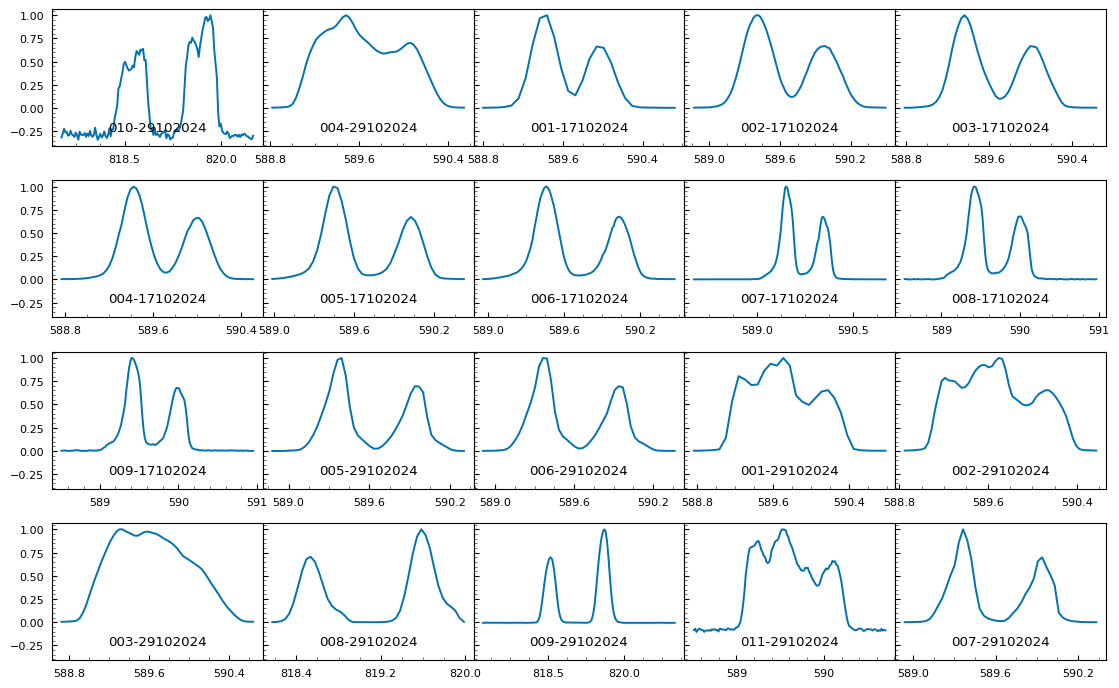

In [9]:
from matplotlib import ticker
import ast

def get_info(x):
    meta = ast.literal_eval(x['meta'])
    return pd.Series(meta)
# info table 
info = Na_df.apply(get_info, axis=1)
display(info)

with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):       
    fig, axs = plt.subplots(4, 5, figsize=FIG_SIZE * 1.8, sharey=True)

    # I dont't remeber why I did this but it works 
    # good enough for me to not touch it
    groups = Na_df.groupby('meta')
    for i, [name, group] in enumerate(groups):
        ax = axs.flatten()[i]
        # The data encapsulation is sooooo bad :*(
        # next time I should use a better data structure
        mean = group.get('mean').values[0]
        wl = group.get('wl').values[0]
        

        # normalize the data to show it more clearly
        mean = mean / mean.max()
        
        # keep only the relevant data
        mask = mean > mean.min() + 4e-3
        mean = mean[mask]
        wl = wl[mask]
        
        ax.plot(wl, mean)
        date = group.get('date').values[0]
        the_id = group.get('id').values[0]
        ax.set_title(f'{the_id}-{date}', y = 0.05)
    
    for ax in axs.flatten():
        fmtax(ax, label=False)
        ax.xaxis.set_major_locator(
            ticker.MaxNLocator(nbins= 3, prune='both'))
        
    # adjoust the layout and save
    fig.tight_layout()
    fig.subplots_adjust(wspace=0, right=0.95,
                        hspace=0.25, top=0.95)
    plt.show()
    savefig(fig, fig_name = 'na_spectrum_overview')

We introduced an iris to better focus the light in the monochromator.
Its effect is displayed below.

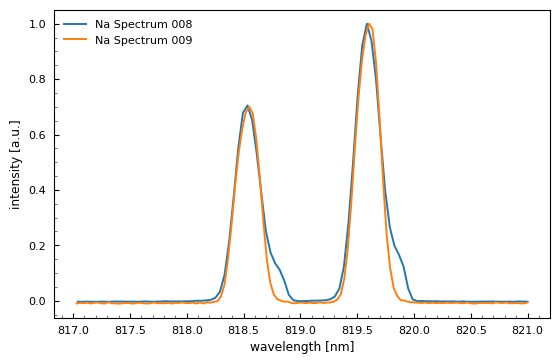

In [10]:
a = Na_df[(Na_df['id'] == '008') & (Na_df['date'] == '29102024')].copy()
b = Na_df[(Na_df['id'] == '009') & (Na_df['date'] == '29102024')].copy()

with plt.style.context(['seaborn-v0_8-paper']):
    fig, ax = plt.subplots( figsize=FIG_SIZE )
    for item, fmt in zip([a, b], ['-', '-']):
        wl = item['wl'].values[0]
        mean = item['mean'].values[0] / item['mean'].values[0].max()
        ax.plot(wl, mean, fmt ,label=f'Na Spectrum {item["id"].values[0]}')
    ax.legend(loc='upper right', frameon=False)
    fmtax(ax, label=True)
    savefig(fig, fig_name = 'na_iris_effect', fig_size=FIG_SIZE)
    plt.show()

# Fitting the data at 800 nm
There should be a noticeable difference between the raw data and the correction of the responce function

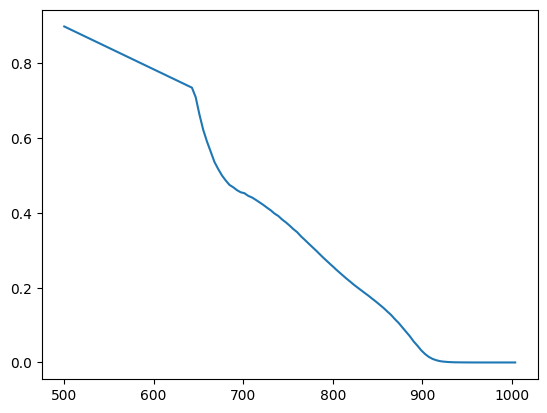

In [11]:
from scipy.interpolate import interp1d
responce = np.loadtxt(path.join(OUT_PATHS['results_dir'], 'responce.csv'), delimiter=',').T
plt.plot(responce[0], responce[1])
plt.show()

In [12]:
from lmfit import Minimizer, create_params, report_fit
from lmfit.lineshapes import gaussian, lorentzian, voigt, linear
from lmfit.models import VoigtModel, LinearModel, ConstantModel

def fit_Na(sample, model, params):
    # get the relevant data
    wl = sample['wl'].values[0]
    mean = sample['mean'].values[0]
    std = sample['std'].values[0]
    
    weights = np.maximum(np.abs(std), 1e-6 / np.sqrt(3))
    weights = 1 / weights

    # fit the data
    result = model.fit(mean, params, weights=weights,  x=wl)
    return result

def plot_Na(sample, result, fig_name):
    
    # style options
    kw = {'marker':'.',
        'capsize':2,
        'linestyle':'none',
        'alpha':.7}
    
    wl = sample['wl'].values[0]
    
    with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):  
        fig = result.plot(data_kws=kw, title=' ')
        fig.tight_layout()
        fig.subplots_adjust(hspace=.08)

        components = result.eval_components(params=result.params, x=wl)

        # major ticks inside
        axs = fig.get_axes()
        axs[0].tick_params(direction='in', which='both')

        # plot the peaks
        ax_peak = fig.add_subplot(313, sharex=axs[0], sharey=axs[1])
        ax_peak.set_ylabel(r'peaks [a.u.]')

        for key in components.keys():
            if key == 'bkg_':
                continue
            label = result.params[f'{key}center'].value
            label = f'{label:.2f} nm'
            ax_peak.plot(wl, components[key], label=label)
            ax_peak.fill_between(wl, components[key], 0, alpha = 0.2)  

        # move it a little down
        pos = ax_peak.get_position()
        delta = pos.height + 0.06
        ax_peak.set_position([pos.x0, pos.y0 - delta, pos.width, pos.height])
        ax_peak.tick_params(direction='in', which='both')
        ax_peak.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax_peak.legend(loc='upper right', frameon=False)
        
        # format the axes
        fmtax(axs[1], loc='upper right', label='y')
        axs[1].set_xlabel(None)
        ax_peak.set_xlabel(r'wavelength [nm]')
        
        # show and save
        plt.show()  
        savefig(fig, fig_name = fig_name) 
        
def correct_sample(sample, responce):
    wl = sample['wl'].values[0]
    mean = np.array(sample['mean'].values[0])
    std = np.array(sample['std'].values[0])
    interp = interp1d(responce[0], responce[1], kind='linear')(wl)
    mean = mean * interp
    std = std * interp

    sample['mean'] = [mean]
    sample['std'] = [std]
    return sample

C:\Users\alber\AppData\Local\Temp\ipykernel_25888\662855959.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['mean'] = [mean]
C:\Users\alber\AppData\Local\Temp\ipykernel_25888\662855959.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['std'] = [std]


{'type': 'Na',
 'integration time': '300ms',
 'PT tension': '410V',
 'id': '005',
 'date': '17102024'}

C:\Users\alber\AppData\Roaming\Python\Python312\site-packages\lmfit\model.py:2203: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_array, reduce_complex(self.data),
C:\Users\alber\AppData\Roaming\Python\Python312\site-packages\lmfit\model.py:2324: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_array, residuals,


[[Model]]
    ((Model(voigt, prefix='one_') + Model(voigt, prefix='two_')) + Model(linear, prefix='bkg_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 99
    # variables        = 10
    chi-square         = 1977.72975
    reduced chi-square = 22.2216826
    Akaike info crit   = 316.463917
    Bayesian info crit = 342.415116
    R-squared          = 0.99605208
[[Variables]]
    one_amplitude:  1.5969e-04 +/- 2.6329e-06 (1.65%) (init = 0.00020098)
    one_center:     589.448475 +/- 0.00196910 (0.00%) (init = 589.4532)
    one_sigma:      0.06422332 +/- 0.00335783 (5.23%) (init = 0.06926168)
    two_amplitude:  9.9390e-05 +/- 1.2716e-06 (1.28%) (init = 0.00012348)
    two_center:     590.017117 +/- 0.00151300 (0.00%) (init = 590.0209)
    two_sigma:      0.08733736 +/- 0.00258866 (2.96%) (init = 0.08952652)
    bkg_slope:      5.1477e-07 +/- 3.8064e-07 (73.94%) (init = 6.132099e-08)
    bkg_intercept: -3.0493e-04 +/- 2.2428e-04 

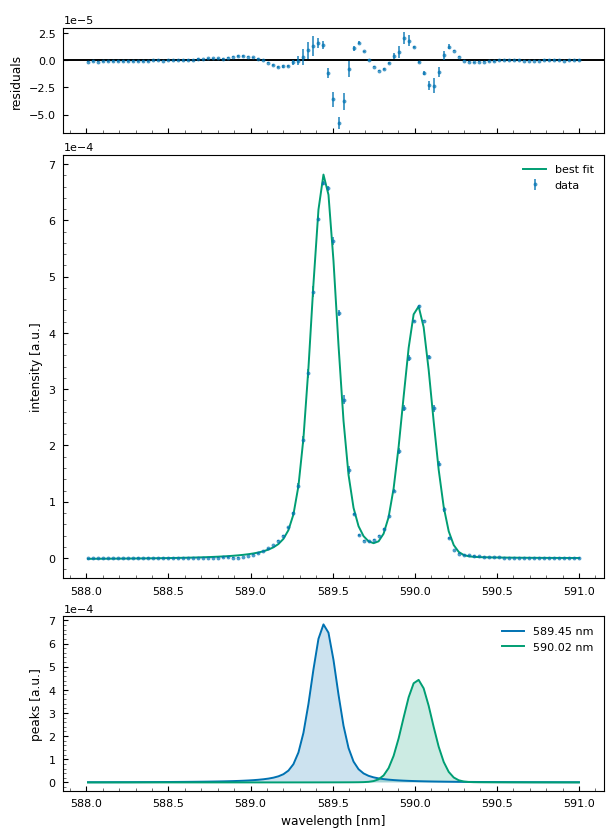

In [13]:
mask = (Na_df['date'] == '17102024') & (Na_df['id'] == '005')
sample = Na_df[mask]
sample = correct_sample(sample, responce)
display(ast.literal_eval(sample['meta'].values[0]))

# create the model and init the parameters
model = VoigtModel(prefix='one_') + VoigtModel(prefix='two_') + LinearModel(prefix='bkg_')
params = model.make_params()

params['one_center'].set(589.453201, min=589, max=590.5)
params['one_sigma'].set(0.06926168)
params['one_gamma'].set(0.02878824, vary=True)
params['one_amplitude'].set(2.0098e-4, min=1e-5)

params['two_center'].set(590.020911, min=589, max=590.5)
params['two_sigma'].set(0.08952652)
params['two_gamma'].set(-0.00139832, vary=True)
params['two_amplitude'].set(1.2348e-4, min=1e-5)

params['bkg_slope'].set(6.132099e-08, vary=True)
params['bkg_intercept'].set(-3.62328e-05, vary=True)

        
result = fit_Na(sample, model, params)
print(result.fit_report())
plot_Na(sample, result, 'Na_17102024_005')  
# exp 0.539  vs theo 0.597 diff 0.058
# exp 589.448 theo 588.995 diff 0.453

C:\Users\alber\AppData\Local\Temp\ipykernel_25888\662855959.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['mean'] = [mean]
C:\Users\alber\AppData\Local\Temp\ipykernel_25888\662855959.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['std'] = [std]
C:\Users\alber\AppData\Roaming\Python\Python312\site-packages\lmfit\model.py:2203: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence

[[Model]]
    ((Model(voigt, prefix='one_') + Model(voigt, prefix='two_')) + Model(linear, prefix='bkg_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 191
    # data points      = 129
    # variables        = 10
    chi-square         = 62.3483953
    reduced chi-square = 0.52393609
    Akaike info crit   = -73.7926066
    Bayesian info crit = -45.1944826
    R-squared          = 0.99743204
[[Variables]]
    one_amplitude:  5.6581e-06 +/- 1.2912e-07 (2.28%) (init = 3.67e-05)
    one_center:     818.538599 +/- 0.00103573 (0.00%) (init = 818.5)
    one_sigma:      0.10935377 +/- 0.00327451 (2.99%) (init = 0.009)
    two_amplitude:  7.9865e-06 +/- 1.3191e-07 (1.65%) (init = 3.67e-05)
    two_center:     819.597687 +/- 7.3600e-04 (0.00%) (init = 819.6)
    two_sigma:      0.10753953 +/- 0.00235739 (2.19%) (init = 0.009)
    bkg_slope:      1.2731e-08 +/- 3.5041e-08 (275.23%) (init = 0)
    bkg_intercept: -1.0568e-05 +/- 2.8697e-05 (271.55%) (init = 0)
    o

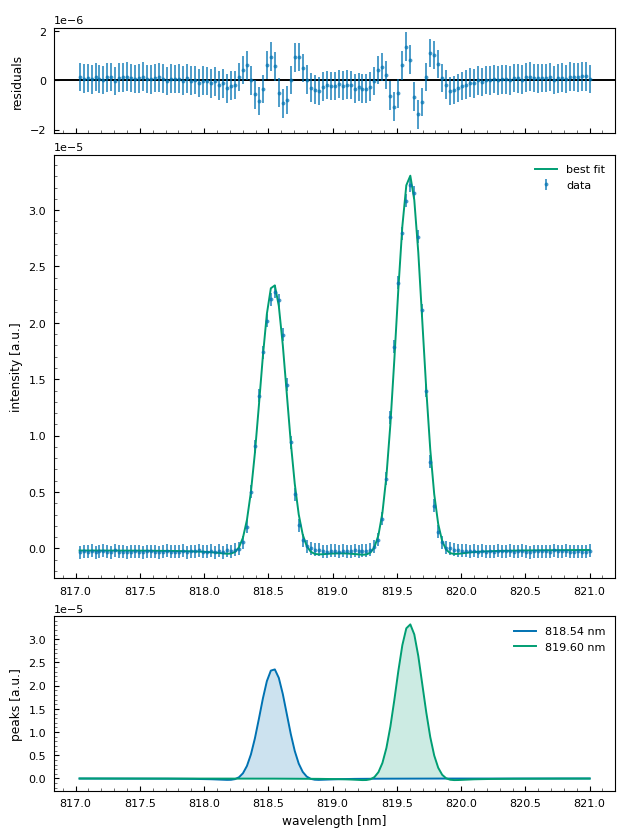

In [14]:
# fitting at 
mask = (Na_df['date'] == '29102024') & (Na_df['id'] == '009')
sample = Na_df[mask]
sample = correct_sample(sample, responce)

params = model.make_params()
params['one_center'].set(818.5)
params['one_sigma'].set(0.009)
params['one_gamma'].set(0.011,vary=True)
params['one_amplitude'].set(3.67e-5)

params['two_center'].set(819.6)
params['two_sigma'].set(0.009)
params['two_gamma'].set(0.0074, vary=True)
params['two_amplitude'].set(3.67e-5)

params['bkg_slope'].set(0, vary=True)
params['bkg_intercept'].set(0, vary=True)

result = fit_Na(sample, model, params)
print(result.fit_report())
plot_Na(sample, result, 'Na_29102024_009')

# exp 818.539 theo 818.326 diff 0.213
# exp 819.600 theo 819.479 diff 0.121
# exp 1.060 theo 1.153 diff 0.093